In [1]:
import urllib.request
import json
import sqlite3

## pilote

token = "2e5878db2e5878db2e5878dbd92e31ba7022e582e5878db72f00bd860eb2a7ea0991f60"
owner_id = "-14148503"
Ladybug_comments = ''
post_id = "1518119"

def load_comments(token, owner_id, post_id, post_text, post_date):
    req = urllib.request.Request('https://api.vk.com/method/wall.getComments?owner_id={}&post_id={}&count=100&v=5.92&access_token={}'.format(owner_id, post_id, token))
    response = urllib.request.urlopen(req)
    result = response.read().decode('utf-8')
    comments_data = json.loads(result)
    comments_number = comments_data['response']['current_level_count']
    post_date = datetime.fromtimestamp(post_date)
    post_date = post_date.strftime('%Y-%m-%d') 
    conn = sqlite3.connect('./Miraculous_Ladybug_corpora/ladybug_corpora.db')
    c = conn.cursor()
    c.execute("CREATE TABLE IF NOT EXISTS posts(post_id, post_text, post_date)")
    c.execute("INSERT INTO posts VALUES (?, ?, ?)", (post_id, post_text, post_date))
    conn.commit()
    conn.close()
##    with open("posts_info.csv", "a", encoding="utf-8") as f1:
##        posts_info = '{}\t{}\t{}\n'.format(post_id, post_text, post_date)
##        f1.write(posts_info)
    for i in range(comments_number):
        req = urllib.request.Request('https://api.vk.com/method/wall.getComments?owner_id={}&post_id={}&fields={}&offset={}&count=1&v=5.92&access_token={}&extended=1'.format(owner_id, post_id, "bdate,city,sex", i, token))
        response = urllib.request.urlopen(req)
        result = response.read().decode('utf-8')
        comments_data = json.loads(result)
        try:
            update(post_id, comments_data, owner_id)
        except KeyError:
            continue

In [2]:
from datetime import datetime
import sqlite3
import os

def make_directory():
    directory = "./Miraculous_Ladybug_corpora/plain_text"
    if not os.path.exists(directory):
        os.makedirs(directory)

def update(post_id, comments_data, owner_id):
    comment_text = comments_data['response']['items'][0]['text']
    comment_id = comments_data['response']['items'][0]['id']
    comment_date = comments_data['response']['items'][0]['date']
    comment_date = datetime.fromtimestamp(comment_date)
    comment_date = comment_date.strftime('%Y-%m-%d') 
    user_id = comments_data['response']['items'][0]['from_id']
    try:
        user_name = comments_data['response']['profiles'][0]['first_name']
    except IndexError:
        return
    user_gender = comments_data['response']['profiles'][0]['sex']
    if comments_data['response']['profiles'][0]['is_closed'] == True:
        user_city, user_bdate = 'unknown', 'unknown'
    else:
        if 'bdate' not in comments_data['response']['profiles'][0]:
            user_bdate = 'unknown'
        else:
            user_bdate = comments_data['response']['profiles'][0]['bdate']
        if 'city' not in comments_data['response']['profiles'][0]:
            user_city = 'unknown'
        else:
            user_city = comments_data['response']['profiles'][0]['city']['name']
    conn = sqlite3.connect('./Miraculous_Ladybug_corpora/ladybug_corpora.db')
    c = conn.cursor()
    c.execute("CREATE TABLE IF NOT EXISTS comments(post_id, comment_id, comment_text, user_id, user_name, user_city, user_bdate, user_gender)")
    c.execute("INSERT INTO comments VALUES (?, ?, ?, ?, ?, ?, ?, ?)", (str(post_id), comment_id, comment_text, str(user_id), user_name, user_city, user_bdate, user_gender))
    conn.commit()
    conn.close()
##    with open("comments_info.csv", "a", encoding="utf-8") as f2:
##        comments_info = '{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\n'.format(post_id, comment_id, comment_text, user_id, user_name, user_city, user_date, user_gender)
##        f2.write(comments_info)

In [3]:
import sqlite3

def make_corpora():
    text = ''
    filename = './Miraculous_Ladybug_corpora/plain_text/plain_text.txt'
    conn = sqlite3.connect('./Miraculous_Ladybug_corpora/ladybug_corpora.db')
    c = conn.cursor()
    for row in c.execute("SELECT * FROM posts"):
        text += 'post ' + str(row[0]) + '\n' + row[1] + '\n'
    conn.close()
    conn = sqlite3.connect('./Miraculous_Ladybug_corpora/ladybug_corpora.db')
    c = conn.cursor() 
    for row in c.execute("SELECT * FROM comments"):
            text += 'comment ' + row[0] +'\n' + row[2] + '\n'
    conn.close()
    print('ok')
    with open(filename, "w", encoding="utf-8") as f:
        f.write(text)

In [4]:
import urllib.request
import json

## Здесь я пройдусь циклом по 1000 постов, выкачивая пост, дату его создания 
## (её буду заносить в базу в таблицу posts), все комментарии к посту, а также информацию о каждом комментарии, 
## которую буду заносить в базу в таблицу с названием формата post_id 
## (время, id пользователя, город, возраст, пол, имя)

##def create_database():
    
token = "2e5878db2e5878db2e5878dbd92e31ba7022e582e5878db72f00bd860eb2a7ea0991f60"
owner_id = "-14148503"
n = 10
make_directory()
##with open("posts_info.csv", "w", encoding="utf-8") as f1:
##    f1.write("post_id\tpost_text\tpost_date\n")
##with open("comments_info.csv", "w", encoding="utf-8") as f2:
##    f2.write("post_id\tcomment_id\tcomment_text\tuser_id\tuser_name\tuser_city\tuser_bdate\tuser_gender\n")
for i in range(n):
    print(i)
    offset = str(i*100 + 10)
    req = urllib.request.Request('https://api.vk.com/method/wall.get?owner_id={}&offset={}&count=100&v=5.92&access_token={}'.format(owner_id, offset, token)) 
    response = urllib.request.urlopen(req)
    result = response.read().decode('utf-8')
    data = json.loads(result)
    for j in range(100):
        print(j)
        post_text = data['response']['items'][j]['text']
        post_id = data['response']['items'][j]['id']
        post_date = data['response']['items'][j]['date']
        load_comments(token, owner_id, post_id, post_text, post_date)


0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
2
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
3
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43


TypeError: make_corpora() missing 1 required positional argument: 'post_id'

In [4]:
make_corpora()

ok


['Какие', 'ощущения', 'вы', 'испытываете,', 'когда', 'в', 'сериале', 'подтверждается', 'какая-то', 'из', 'ваших', '(или', 'полюбившихся', 'вам)', 'теорий?']
['#ladybug_arts@miraculousladybug', 'Автор', '-', 'enaikka_']
['Содержание', '99%', 'сообщений,', 'которые', 'нам', 'пишут', 'в', 'личку', 'группы:']
['#ladybug_arts@miraculousladybug', 'Автор', '-', 'drag0steadintei']
['#ladybug_arts@miraculousladybug', 'Автор', '-', 'helpme_LDB']
[]
['#админ_исполняет_мечты@miraculousladybug', 'Тем', 'временем,', 'я', 'наконец-то', 'посмотрела', 'трейлер', 'и', 'заметила,', 'что', 'в', 'эпизоде', '"Бейкерикс"', 'нас', 'ждет', 'новая', 'локация.', 'Да', 'еще', 'какая', '-', 'Северный', 'вокзал!', 'Возле', 'нее', 'мне', 'удалось', 'побывать,', 'и', 'это', 'не', 'потому', 'что', 'я', 'Ванга', 'и', 'видела', 'будущее,', 'так', 'вышло,', 'что', 'я', 'рядом', 'жила.', 'Увы,', 'проходя', 'там', 'каждый', 'день,', 'так', 'и', 'не', 'догадалась', 'сфоткать', 'это', 'огромное', 'массивное', 'произведение',

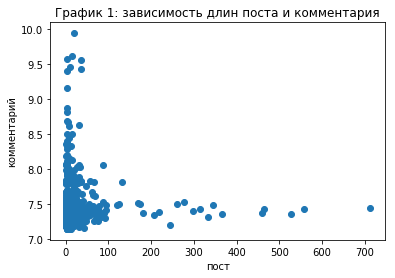

TypeError: unsupported operand type(s) for /: 'str' and 'int'

<Figure size 432x288 with 0 Axes>

In [13]:
# у всех графиков --  подписи осей, подписи делений и заголовок
# график 1: зависимость длины поста и средней длины комментария в словах
# график 2: зависимость длины поста от дня публикации
# график 3: зависимость длины поста от хэштэга в посте
# график 4: зависимость длины комментария от города комментатора
# график 5: зависимость длины комментария от пола комментатора
# график 6: первые 25 частотных слов в постах и комментариях
# график 7: первые 25 частотных лемматизированных слов в постах и комментариях
import matplotlib.pyplot as plt
import re


def mean(numbers):
    return float(sum(numbers)) / max(len(numbers), 1)


def graphs():
    post_ids = []
    post_length = []
    comment_length = []
    post_day = []
    post_tag = []
    conn = sqlite3.connect('./Miraculous_Ladybug_corpora/ladybug_corpora.db')
    c = conn.cursor()
    for row in c.execute("SELECT post_id, post_text, post_date FROM posts"):
        post_ids.append(str(row[0]))
        post_words = row[1].split()
        post_day.append(row[2].split('-')[2])
        print(post_words)
        count = len(re.findall(r'\w+', row[1]))
        post_length.append(count)
        match = re.search('(#.+?) ', row[1])
        if match:
            post_tag.append(match.group(1))
        else:
            post_tag.append("нет тэга")
    conn.close()
    conn = sqlite3.connect('./Miraculous_Ladybug_corpora/ladybug_corpora.db')
    c = conn.cursor()
    count1 = []
    for post_id in post_ids:
        for row in c.execute("SELECT comment_text FROM comments WHERE post_id=?", (post_id,)):
            comment_words = row[0].split()
            count1.append(len(re.findall(r'\w+', row[0])))
        comment_length.append(mean(count1))
    conn.close()
    plt.scatter(post_length, comment_length)
    plt.title('График 1: зависимость длин поста и комментария')
    plt.ylabel('комментарий')
    plt.xlabel('пост')
    plt.show()
    plt.savefig('graph1', dpi='300', format='png')
    
    plt.scatter(post_length, post_day)
    plt.title('График 2: зависимость длины поста от дня')
    plt.ylabel('день')
    plt.xlabel('длина поста')
    plt.show()
    plt.savefig('graph1', dpi='300', format='png')
    
    plt.scatter(post_tag, post_length)
    plt.title('График 3: зависимость длины поста от тэга')
    plt.ylabel('длина поста')
    plt.xlabel('тэг')
    plt.show()
    plt.savefig('graph1', dpi='300', format='png')
    
    plt.scatter(post_tag, post_length)
    plt.title('График 3: зависимость длины поста от тэга')
    plt.ylabel('длина поста')
    plt.xlabel('тэг')
    plt.show()
    plt.savefig('graph1', dpi='300', format='png')

graphs()

In [ ]:
# создаю облака частотных лемматизированных слов
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def make_word_cloud(lem_text):

# картинка, в форме которой будет облако слов
comment_mask = np.array(Image.open("miraculous.jpg"))

cloud = WordCloud(background_color="white", max_words=2000, mask=comment_mask)

# генерируем
cloud.generate(' '.join(lem_text))

# визуализируем
plt.imshow(cloud, interpolation='bilinear')
plt.axis("off")
plt.show()


# store to file
cloud.to_file("lemmas_cloud.png")